# Analyze The Beam Transportation in the Undulator Line

In this file, I plan to analyze the beam tranportation in the undulator line. To be more exactly, I want to analyze the phase space distribution of the bunch when traveling along z. In accelerator physics, we always characterize the electron bunch by the 6D phase space distribution. However, since the energy and the speed in z of one electron doesn't change a lot in the undulator line, we can keep them as constants during the first order approximation. Therefore, given N electrons, we want to consider the $4D \times N$ array, where each column is:
\begin{pmatrix}
x\\
\beta_x\\
y\\
\beta_y
\end{pmatrix}
Here we assume that $v_z = c$ and define $\beta_x = v_x/c$, $\beta_y = v_y/c$. All quantities that has a unit of length should be expressed in meters.

In the first order approximation, we need to consider four types of elements. We will analyze them one by one in the following:

## Quadrupole

We can first assume that a positive K indicates a focusing in X. If this is not correct, you can just analyze it slightly later. Given a positive K value and its length L, the transportation matrix is:
\begin{pmatrix} 
\cos(\sqrt{K}L) & \frac{1}{\sqrt{K}}\sin(\sqrt{K}L) & 0 & 0 \\
-\sqrt{K}\sin(\sqrt{K}L) & \cos(\sqrt{K}L)  & 0 & 0\\
0 & 0 & \cosh(\sqrt{K}L) & \frac{1}{\sqrt{K}}\sinh(\sqrt{K}L) \\
0 & 0 & \sqrt{K}\sinh(\sqrt{K}L) & \cosh(\sqrt{K}L)
\end{pmatrix}

If the input $K$ is negative, the transportation is:
\begin{pmatrix} 
\cosh(\sqrt{|K|}L) & \frac{1}{\sqrt{|K|}}\sinh(\sqrt{|K|}L) & 0 & 0\\
\sqrt{|K|}\sinh(\sqrt{|K|}L) & \cosh(\sqrt{|K|}L)  & 0 & 0\\
0 & 0 & \cos(\sqrt{|K|}L) & \frac{1}{\sqrt{|K|}}\sin(\sqrt{|K|}L) \\
0 & 0 & -\sqrt{|K|}\sin(\sqrt{|K|}L) & \cos(\sqrt{|K|}L)
\end{pmatrix}

There is no shift matrix needed in this part.

## Drift

Drift is easy to be implemented. The transportation matrix is:
\begin{pmatrix} 
1 & L & 0 & 0 \\
0 & 1  & 0 & 0\\
0 & 0 & 1 & L \\
0 & 0 & 0 & 1
\end{pmatrix}

## Orbit Corrector

In experiment, the orbit correction is implemented by the bending in the dipole. In order to charactrize an orbit corrector, we need its length $L$ and the angle kicks $cx, cy$ in X and Y. Based in my understanding, angle kicks are defined as $\Delta \beta_x$ and $\Delta \beta_y$ rather than $\gamma \Delta \beta_x$ or $\gamma \Delta \beta_y$.

After passing the orbit corrector, one electron with initial phase space $(x, \beta_x, y, \beta_y)$ will go to $(x+(\beta_x+\frac{1}{2}cx)L, \beta_x+cx, y+(\beta_y+\frac{1}{2}cy)L, \beta_y+cy)$. Therefore, expressed in the language of matrix manipulations, the orbit correction can be characterized by a drift together with a shift. The drift matrix is:
\begin{pmatrix} 
1 & L & 0 & 0 \\
0 & 1  & 0 & 0\\
0 & 0 & 1 & L \\
0 & 0 & 0 & 1
\end{pmatrix}
And the shift matrix is:
\begin{pmatrix}
\frac{1}{2}cx \cdot L \\
cx \\
\frac{1}{2}cy \cdot L\\
cy
\end{pmatrix}

## Chicane

There are two chicanes located in the undulator line. They are used for delaying the electron beam but do not lead to significant beam compression. Indeed, the distance between the 1st and 2nd, 3rd and 4th dipoles are almost 0, which means that $R_{56}$ is almost 0. Given the length $L$ of the chicane, the length $l_b$ of one dipole and the delay $\Delta l$ in a unit of length, the bending angle $\theta$ in one dipole is
\begin{equation}
\theta = \sqrt{\frac{3\Delta l}{2 l_b}}, 
\end{equation}
which is several orders of magnitude larger than the electrons' divergences in X and Y. Therefore, we can just focus on the bending effects of the chicane itself.

One subtle thing we need to take into consideration is the wedge focusing effect of the chicane. In the setup of our GENESIS 4 simulation, the bending effect is in the Y-direction. We assume that the magnetic field is uniform in those four dipoles. Based on this assumption, the wedge focusin effect is only in Y-direction. For one dipole with the length $l_b$, the 4-by-4 transformation matrix is:
\begin{pmatrix} 
1 & l_b & 0 & 0 \\
0 & 1  & 0 & 0\\
0 & 0 & \cos(k_y l_b) & \frac{1}{k_y}\sin(k_y l_b) \\
0 & 0 & -k_y\sin(k_y l_b) & \cos(k_y l_b)
\end{pmatrix}
Here $k^2_y = (1/\rho_0)^2$ and $\rho_0$ is the central bending radius in the dipole. Since $\rho_0 >> l_b$, we can approximate $k^2_y = (\theta/l_b)^2$ where $\theta$ is the bending angle defined in the above. The transformation matrix $M_{\mathrm{dipole}}$ of the dipole can be modeled as:
\begin{pmatrix} 
1 & l_b & 0 & 0 \\
0 & 1  & 0 & 0\\
0 & 0 & \cos(\theta) & \frac{l_b}{\theta}\sin(\theta) \\
0 & 0 & -\frac{\theta}{l_b}\sin(\theta) & \cos(\theta)
\end{pmatrix}

There are totally four dipoles together with one drift in the chicane. Suppose that the chicane has the total length $L$. The drift length between the 2nd and the 3rd dipole is $L-4l_b$. The drift matrix $M_{\mathrm{drift}}$ is:
\begin{pmatrix} 
1 & L-4l_b & 0 & 0 \\
0 & 1  & 0 & 0\\
0 & 0 & 1 & L-4l_b \\
0 & 0 & 0 & 1
\end{pmatrix}

The transformation matrix for the whole chicane is $M^2_{\mathrm{dipole}} \times M_{\mathrm{drift}} \times M^2_{\mathrm{dipole}}$.



## Short Summary

Therefore, we need to build four Python classes. Let's do it in the next section.

In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from scipy import constants

In [11]:
class Quadrupole:
    def __init__(self, L, K):
        self.length = L
        self.focusing = K
        if K > 0:
            self.M1 = [[np.cos(np.sqrt(K)*L), 1/np.sqrt(K)*np.sin(np.sqrt(K)*L), 0, 0],
                       [-np.sqrt(K)*np.sin(np.sqrt(K)*L), np.cos(np.sqrt(K)*L), 0, 0],
                       [0, 0, np.cosh(np.sqrt(K)*L), 1/np.sqrt(K)*np.sinh(np.sqrt(K)*L)],
                       [0, 0, np.sqrt(K)*np.sinh(np.sqrt(K)*L), np.cosh(np.sqrt(K)*L)]]
        else:
            K = np.abs(K)
            self.M1 = [[np.cosh(np.sqrt(K)*L), 1/np.sqrt(K)*np.sinh(np.sqrt(K)*L), 0, 0],
                       [np.sqrt(K)*np.sinh(np.sqrt(K)*L), np.cosh(np.sqrt(K)*L),   0, 0],
                       [0 , 0 , np.cos(np.sqrt(K)*L), 1/np.sqrt(K)*np.sin(np.sqrt(K)*L)],
                       [0 , 0 , -np.sqrt(K)*np.sin(np.sqrt(K)*L), np.cos(np.sqrt(K)*L)]]
        
        self.M2 = [[0],
                   [0],
                   [0],
                   [0]]

class Drift:
    def __init__(self, L):
        self.length = L
        self.M1 = [[1, L, 0, 0],
                   [0, 1, 0, 0],
                   [0, 0, 1, L],
                   [0, 0, 0, 1]]
        self.M2 = [[0],
                   [0],
                   [0],
                   [0]]

class Orbit_Corrector:
    def __init__(self, L, cx, cy):
        self.length = L
        self.kick_x = cx
        self.lick_y = cy
        self.M1 = [[1, L, 0, 0],
                   [0, 1, 0, 0],
                   [0, 0, 1, L],
                   [0, 0, 0, 1]]
        self.M2 = [[0.5*cx*L],
                   [cx],
                   [0.5*cy*L],
                   [cy]]
        
class Chicane:
    def __init__(self, L, lb, ld, delay):
        self.length = L
        self.length_dipole = lb
        self.length_drift_dipole = ld
        self.length_delay = delay
        
        theta = np.sqrt(3*delay/(2*lb))
        M_dipole = [[1, lb, 0, 0],
                   [0, 1, 0, 0],
                   [0, 0, np.cos(theta), (lb/theta)*np.sin(theta)],
                   [0, 0, -(theta/lb)*np.sin(theta), np.cos(theta)]]
        M_drift = [[1, L-4*lb, 0, 0],
                   [0, 1, 0, 0],
                   [0, 0, 1, L-4*lb],
                   [0, 0, 0, 1]]
        
        self.M1 = np.linalg.multi_dot([M_dipole, M_dipole, M_drift, M_dipole, M_dipole])
        self.M2 = [[0],
                   [0],
                   [0],
                   [0]]


In [12]:
def beam_transportation(init_phase_spc, undulator_line):
    """Input:
    init_phase_space: A 4-by-N array, which is the 4D phase space of the bunch. N
    is the number of macroparticles in the bunch.
    undulator_line: A list which contains components defined in the previous section."""
    
    phase_spc = init_phase_spc
    
    for element in undulator_line:
        phase_space = np.dot( element.M1, phase_spc ) +element.M2
    
    return phase_space

## Analyze twiss parameters of the bunch

We need to find some ways to charactrize the quanlity of the bunch. The geometric emittance is defined as:
\begin{equation}
\epsilon_x = \sqrt{\langle x^2 \rangle \langle x^{\prime 2} \rangle - \langle x x^{\prime}\rangle^2} .
\end{equation}
The Courant-Synder or twiss parameters are defined as 
\begin{equation}
\beta_x = \frac{\langle x^2 \rangle}{\epsilon_x} ,
\end{equation}
\begin{equation}
\gamma_x = \frac{\langle {x^{\prime}}^2 \rangle}{\epsilon_x} ,
\end{equation}
\begin{equation}
\alpha_x = -\frac{\langle x x^{\prime} \rangle}{\epsilon_x}.
\end{equation}
We can also define a set of twiss parameters to characterize the beam distribution in Y in the same way. In the following, we keep using the same 4D phase space distribution:
\begin{pmatrix}
x\\
\beta_x\\
y\\
\beta_y
\end{pmatrix}


In [13]:
def emittance_and_twiss(ps_4D):
    """Input:
    ps_4D: A 4-by-N array, which is the 4D phase space of the bunch. N
    is the number of macroparticles in the bunch.
    Output:
    alpha_x, beta_x, gamma_x, emittance_x, alpha_y, beta_y, gamma_y, emittance_y:
    All are real numbers.
    """
    x = ps_4D[0,:]
    xp = ps_4D[1,:]
    y = ps_4D[2,:]
    yp = ps_4D[3,:]
    
    emittance_x = np.sqrt(np.average(x**2)*np.average(xp**2)-np.average(np.multiply(x, xp))**2)
    alpha_x = -np.average(np.multiply(x, xp))/emittance_x
    beta_x = np.average(x**2)/emittance_x
    gamma_x = np.average(xp**2)/emittance_x
    
    emittance_y = np.sqrt(np.average(y**2)*np.average(yp**2)-np.average(np.multiply(y, yp))**2)
    alpha_y = -np.average(np.multiply(y, yp))/emittance_y
    beta_y = np.average(y**2)/emittance_y
    gamma_y = np.average(yp**2)/emittance_y
    
    return emittance_x, alpha_x, beta_x, gamma_x, emittance_y, alpha_y, beta_y, gamma_y

## Flip the input beam and analyze the temporal distribution along s

One subtle difference between the beam profile in ELEGANT and in GENESIS 4 is where the head of the bunch is. In ELEGANT, the head of the beam is on the left-hand-side. Whereas in GENESIS 4, the head of the beam is on the right-hand-side. In order to make sure that we are comparing apple to apple, we need to flip the beam and convert the information from time (t) to the longitudinal length along the bunch(s).

At the same time, we also want to do put particlles into slices along s. The built-in function np.hist in Python is already good enough to do this job.

In [14]:
def flip_slice(t):
    """We use this function to flip the bunch in s and convert the information from
    time (t) to the longitudinal length along the bunch(s).
    Input:
    t: An array which has the length N. N is the number of particles.
    Output:
    id_slices: A list of length N_bin, where N_bin is the number of mesh grids in
    the histogram. The list id_slices[i-1] contains the indices of partciles in the
    i-th mesh grid in s.
    zplot: A array of length N_bin. It is the array of bin edges in s."""

    s = constants.c*np.ravel((np.max(t)-t)) # Flip s
    s_sort_index = np.argsort(s) # Ascending order.
    
    bins = 200
    plt.clf()
    hist, zplot, patches = plt.hist(s, bins)
    
    id_slices = []
    for n in range(0, bins):
        num_begin = int(np.sum(hist[0:n]))
        num_end = int(np.sum(hist[0:n+1]))
        id_slices.append(s_sort_index[num_begin:num_end])
        
    return id_slices, zplot
    

## Analyze the beam property along s

In [15]:
def beam_property_along_s(ps, id_slices):
    """We use this function to analyze the beam property along s.
    Input:
    ps: A 4-by-N array. N is the number of macro-particles.
    id_slices: A list of length N_bin, where N_bin is the number of mesh grids in
    the histogram. The list id_slices[i-1] contains the indices of partciles in the
    i-th mesh grid in s.
    Output:
    prop_s: A 14-by-N_bin array. For each column, elements are: average of x, px, y, py, x_RMS
    y_RMS, and emittance_x, alpha_x, beta_x, gamma_x, emittance_y, alpha_y, beta_y, gamma_y."""
    
    prop_s = np.zeros((14, len(id_slices)))
    for n in range(len(id_slices)):
        ps_s = np.take(ps, id_slices[n], axis=1)
        prop_s[0, n] = np.average(ps_s[0,:])
        prop_s[1, n] = np.average(ps_s[1,:])
        prop_s[2, n] = np.average(ps_s[2,:])
        prop_s[3, n] = np.average(ps_s[3,:])
        prop_s[4, n] = np.std(ps_s[0,:])
        prop_s[5, n] = np.std(ps_s[2,:])
        prop_s[6:, n] = emittance_and_twiss(ps_s)
    
    return prop_s
        

## Initialize all the components

In [16]:
### QUAD ###
QUAD01=Quadrupole(0.078,-1.919451488669702e+00)
QUAD02=Quadrupole(0.078,+1.919451488669702e+00)
QUAD03=Quadrupole(0.078,-1.919451488669702e+00)
QUAD04=Quadrupole(0.078,+1.919451488669702e+00)
QUAD05=Quadrupole(0.078,-1.919451488669702e+00)
QUAD06=Quadrupole(0.078,+1.919451488669702e+00)
QUAD07=Quadrupole(0.078,-1.919451488669702e+00)
QUAD08=Quadrupole(0.078,+1.919451488669702e+00)
QUAD09=Quadrupole(0.078,-1.919451488669702e+00)
QUAD10=Quadrupole(0.078,+1.919451488669702e+00)
QUAD11=Quadrupole(0.078,-1.919451488669702e+00)
QUAD12=Quadrupole(0.078,+1.919451488669702e+00)
QUAD13=Quadrupole(0.078,-1.919451488669702e+00)
QUAD14=Quadrupole(0.078,+1.919451488669702e+00)
QUAD15=Quadrupole(0.078,-1.919451488669702e+00)
QUAD16=Quadrupole(0.078,+1.919451488669702e+00)
QUAD17=Quadrupole(0.078,-1.919451488669702e+00)
QUAD18=Quadrupole(0.078,+1.919451488669702e+00)
QUAD19=Quadrupole(0.078,-1.919451488669702e+00)
QUAD20=Quadrupole(0.078,+1.919451488669702e+00)
QUAD21=Quadrupole(0.078,-1.919451488669702e+00)
QUAD22=Quadrupole(0.078,+1.919451488669702e+00)
QUAD23=Quadrupole(0.078,-1.919451488669702e+00)
QUAD24=Quadrupole(0.078,+1.919451488669702e+00)

In [17]:
### Drift ###
D1 = Drift( 0.261 )
D2 = Drift( 0.411 )

## In the first-order approximation, I will also treat those undulators as a drift.

UND01 = Drift( 0.03*110 )
UND02 = Drift( 0.03*110 )
UND03 = Drift( 0.03*110 )
UND04 = Drift( 0.03*110 )
UND05 = Drift( 0.03*110 )
UND06 = Drift( 0.03*110 )
UND07 = Drift( 0.03*110 )
UND08 = Drift( 0.03*110 )
UND09 = Drift( 0.03*110 )
UND10 = Drift( 0.03*110 )
UND11 = Drift( 0.03*110 )
UND12 = Drift( 0.03*110 )
UND13 = Drift( 0.03*110 )
UND14 = Drift( 0.03*110 )
UND15 = Drift( 0.03*110 )
UND16 = Drift( 0.03*110 )
UND17 = Drift( 0.03*110 )
UND18 = Drift( 0.03*110 )
UND19 = Drift( 0.03*110 )
UND20 = Drift( 0.03*110 )
UND21 = Drift( 0.03*110 )
UND22 = Drift( 0.03*110 )
UND23 = Drift( 0.03*110 )
UND24 = Drift( 0.03*110 )

In [18]:
### Orbit Corrector ### 
CORR00 = Orbit_Corrector( 0.001, 0e-6, -75e-6)
CORR01 = Orbit_Corrector( 0.411, 0, 0)
CORR02 = Orbit_Corrector( 0.411, 0, 0)
CORR03 = Orbit_Corrector( 0.411, 0, 0)
CORR04 = Orbit_Corrector( 0.411, 0, 0)
CORR05 = Orbit_Corrector( 0.411, 0, 0)
CORR06 = Orbit_Corrector( 0.411, 0, 0)
CORR07 = Orbit_Corrector( 0.411, 0, 0)

CORR08 = Orbit_Corrector( 0.411, -5e-6, -6e-5)
CORR09 = Orbit_Corrector( 0.411, 0, 2.2e-5);
CORR10 = Orbit_Corrector( 0.411, 0, 0)
CORR11 = Orbit_Corrector( 0.411, 0, 0)
CORR12 = Orbit_Corrector( 0.411, 0, 0)
CORR13 = Orbit_Corrector( 0.411, 0, 0)
CORR14 = Orbit_Corrector( 0.411, 0, 0)
    
CORR15 = Orbit_Corrector( 0.411, 0, 2.5e-5);
CORR16 = Orbit_Corrector( 0.411, 0, 1e-5);
CORR17 = Orbit_Corrector( 0.411, 0, 0)
CORR18 = Orbit_Corrector( 0.411, 0, 0)
CORR19 = Orbit_Corrector( 0.411, 0, 0)
CORR20 = Orbit_Corrector( 0.411, 0, 0)
CORR21 = Orbit_Corrector( 0.411, 0, 0)
CORR22 = Orbit_Corrector( 0.411, 0, 0)
CORR23 = Orbit_Corrector( 0.411, 0, 0)
CORR24 = Orbit_Corrector( 0.411, 0, 0)

In [19]:
### Chicane ### 
SXSS = Chicane( 3, 0.1, 0.0, 2.75e-06)

HXSS = Chicane( 3, 0.1, 0.0, 6e-06)

## Construct the undulator line

In [32]:
U1 = [ CORR00,
UND01, D1, QUAD01, CORR01,
UND02, D1, QUAD02, CORR02,
UND03, D2, QUAD03, CORR03,
UND04, D1, QUAD04, CORR04,
UND05, D1, QUAD05, CORR05,
UND06, D2, QUAD06, CORR06,
UND07, D1, QUAD07, CORR07,
UND08, D1, QUAD08, CORR08]

U3 =  [CORR00,
UND01, D1, QUAD01, CORR01,
UND02, D1, QUAD02, CORR02,
UND03, D2, QUAD03, CORR03,
UND04, D1, QUAD04, CORR04,
UND05, D1, QUAD05, CORR05,
UND06, D2, QUAD06, CORR06,
UND07, D1, QUAD07, CORR07,
UND08, D1, QUAD08, CORR08,
 SXSS, D2, QUAD09, CORR09,
UND10, D1, QUAD10, CORR10,
UND11, D1, QUAD11, CORR11,
UND12, D2, QUAD12, CORR12,
UND13, D1, QUAD13, CORR13,
UND14, D1, QUAD14, CORR14,
UND15, D2, QUAD15, CORR15,
 HXSS, D1, QUAD16, CORR16,
UND17, D1, QUAD17, CORR17,
UND18, D2, QUAD18, CORR18,
UND19, D1, QUAD19, CORR19,
UND20, D1, QUAD20, CORR20,
UND21, D2, QUAD21, CORR21,
UND22, D1, QUAD22, CORR22,
UND23, D1, QUAD23, CORR23,
UND24, D2, QUAD24, CORR24]

## Initialize the beam profile

In [33]:
bunch = h5py.File('LTU.bun', 'r')
list(bunch.keys())

['Charge',
 'IDSlotsPerBunch',
 'Particles',
 'SVNVersion',
 'Step',
 'p',
 'pCentral',
 'particleID',
 't',
 'x',
 'xp',
 'y',
 'yp']

In [80]:
# init_ps = [[bunch["x"]], [bunch["xp"]], [bunch["y"]], [bunch["yp"]]]
num = len(bunch["x"])
init_ps = np.zeros((4, num))
init_ps[0,:] = bunch["x"]
init_ps[1,:] = bunch["xp"]
init_ps[2,:] = bunch["y"]
init_ps[3,:] = bunch["yp"]

In [81]:
beamline = [CORR00]

ps_end = beam_transportation(init_ps, U3)

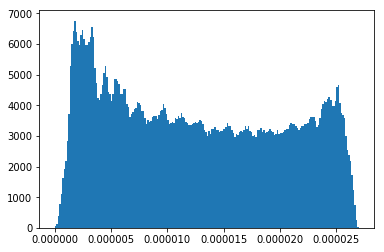

In [36]:
[id_slices, zplot] = flip_slice(bunch["t"])

In [82]:
ps_beg_s = beam_property_along_s(init_ps, id_slices)
ps_end_s = beam_property_along_s(ps_end, id_slices)

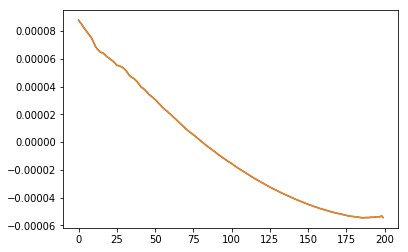

In [85]:
plt.plot(ps_beg_s[3,:])
plt.plot(ps_end_s[3,:])

In [79]:
# plt.hist2d(np.ravel(np.max(bunch["t"])-bunch["t"]), np.ravel(bunch["xp"]), 200)
init_ps[:,0]-ps_end[:,0]

array([-1.80539382e-06,  0.00000000e+00, -7.86481020e-06,  0.00000000e+00])

In [89]:
np.shape(init_ps)

(4, 723422)

In [91]:
test_ps = init_ps+CORR00.M2

In [94]:
test_ps[:,1]

array([-1.34328018e-04,  7.40244783e-06, -1.45370719e-04, -5.53502146e-05])

In [95]:
init_ps[:,1]

array([-1.34328018e-04,  7.40244783e-06, -1.45333219e-04,  1.96497854e-05])